In [85]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange
from scipy.stats import qmc
from scipy.stats import norm, ttest_ind
import os
from tqdm import tqdm
import pandas as pd

In [86]:
SAVE_DIR = 'media'
os.makedirs(SAVE_DIR, exist_ok=True)
np.random.seed(33)

# Complex plane boundaries
X_LIM = (-2, 0.75)
Y_LIM = (-1.25, 1.25)

In [87]:
@jit(nopython=True)
def mandelbrot(z, max_iter) -> int:
    """
    Determine if a complex point is in the Mandelbrot set.
    :param z: Complex point
    :param max_iter: Maximum number of iterations to determine set membership
    :return: Iteration count when z escapes the set, `max_iter` if it doesn't
    """
    c = z
    for i in range(max_iter):
        if np.abs(z) > 2:
            return i
        z = z*z + c
    return max_iter

def bootstrap_confidence_interval(data, num_bootstrap_iters=1000, confidence_level=0.95):
    """
    Compute the bootstrap confidence interval for a dataset.
    :param data: Dataset
    :param num_bootstrap_iters: Number of bootstrap iterations
    :param confidence_level: Confidence level
    :return: Calculated percentile interval
    """
    bootstrap_means = np.empty(num_bootstrap_iters)
    for i in range(num_bootstrap_iters):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_means[i] = np.mean(bootstrap_sample)
    return np.percentile(bootstrap_means, [(1 - confidence_level) / 2 * 100, (1 + confidence_level) / 2 * 100])

def hypothesis_testing(data1, data2, alpha=0.05):
    """
    Perform hypothesis testing to compare two datasets.
    :param data1: First dataset
    :param data2: Second dataset
    :param alpha: Significance level
    :return: Test statistic and p-value
    """
    stat, p_value = ttest_ind(data1, data2)
    if p_value < alpha:
        print("Reject the null hypothesis, indicating a significant difference between the two samples.")
    else:
        print("Fail to reject the null hypothesis, indicating no significant difference between the two samples.")
    return stat, p_value

def mandelbrot_statistics(c_points, counts, method, previous_stats=None, tolerance=0.01, print_output=True):
    """
    Generate statistics of Mandelbrot set points.
    :param c_points: Complex points
    :param counts: Iteration counts for each point
    :param method: Method used for generating the points
    :param previous_stats: Previous statistical data for comparison
    :param tolerance: Tolerance level for determining significant changes
    :return: Statistical results
    """
    total_area = abs(X_LIM[0] - X_LIM[1]) * abs(Y_LIM[0] - Y_LIM[1])
    max_iter = np.max(counts)
    mandelbrot_ratio = np.count_nonzero(counts == max_iter) / counts.size
    mandelbrot_area = total_area * mandelbrot_ratio
    inside = counts == max_iter
    area_samples = inside / (counts.size / total_area)
    sample_mean = np.mean(area_samples)
    sample_std = np.std(area_samples, ddof=1)  # ddof=1 for sample std. dev.
    confidence_interval = norm.interval(0.95, loc=sample_mean, scale=sample_std / np.sqrt(area_samples.size))

    has_converged = False
    if previous_stats:
        mean_change = abs(previous_stats['mean'] - sample_mean)
        std_change = abs(previous_stats['std'] - sample_std)
        if mean_change < tolerance and std_change < tolerance:
            has_converged = True
    
    stats = {
        'area': mandelbrot_area,
        'mean': sample_mean,
        'std': sample_std,
        'conf_int': confidence_interval,
        'has_converged': has_converged
    }
    
    # Print only if there's a significant change or upon convergence
    if print_output and (not previous_stats or mean_change >= tolerance or std_change >= tolerance or has_converged):
        print(f"Mandelbrot area: {mandelbrot_area} using {method} method")
        print(f"Mean estimated area: {sample_mean}")
        print(f"Standard deviation of estimated area: {sample_std}")
        print(f"95% Confidence interval for the estimated area: {confidence_interval}")
        if has_converged:
            print("Stopping criterion met - simulation has converged.")
    
    return stats

def plot_mandelbrot(c_points, counts, method, max_iter=250, save=True, show=True):
    """
    Basic functionality to plot the mandelbrot set.
    :param c_points: Complex points
    :param counts: Iteration counts for each point
    :param method: Method used for generating the points
    :param max_iter: Maximum number of iterations
    :param save: Whether to save the plot
    :param show: Whether to show the plot
    """
    N = int(np.sqrt(len(counts)))
    plt.figure(figsize=(6, 4))

    match(method):
        case 'fixed':
            image_data = counts.reshape(N, N)
            plt.imshow(image_data, cmap='binary', extent=[*X_LIM, *Y_LIM])
        case 'monte-carlo' | 'lhs' | 'orthogonal' | 'random':
            image_data = np.zeros((N, N), dtype=np.int32)
            for i, c_point in enumerate(c_points):
                x_index = int((c_point.real - X_LIM[0]) / (X_LIM[1] - X_LIM[0]) * N)
                y_index = int((c_point.imag - Y_LIM[0]) / (Y_LIM[1] - Y_LIM[0]) * N)
                image_data[x_index, y_index] = counts[i]
            image_data = np.rot90(image_data)
            plt.imshow(image_data, cmap='binary', extent=[*X_LIM, *Y_LIM])
        case _:
            raise ValueError('Invalid argument, method does not exist.')
    
    plt.title(f'Mandelbrot set generated using {len(counts):.1e} points\nusing the {method} method')
    plt.colorbar(shrink=0.85, label='# iterations')
    plt.xlabel('x (real)')
    plt.ylabel('y (imaginary)')

    if save:
        plt.savefig(f'{SAVE_DIR}/mandelbrot_{method}_{max_iter}_{N}.png', dpi=300)
    if show:
        plt.show()

@jit(nopython=True, parallel=True)
def mandelbrot_parallel_fixed(max_iter=250, size=1_000):
    """
    Generate points on a fixed grid and evaluate their mandelbrot set membership.
    :param max_iter: Maximum iterations
    :param size: Number of points
    :return: Complex points and iteration counts
    """
    real_parts, imag_parts = np.linspace(*X_LIM, size), np.linspace(*Y_LIM, size)
    c_points = np.zeros((size, size), dtype=np.complex128)
    counts = np.zeros((size, size), dtype=np.int32)

    for i in prange(size):
        for j in prange(size):
            z = complex(real_parts[j], imag_parts[i])
            c_points[i, j] = z
            counts[i, j] = mandelbrot(z, max_iter)
    return c_points.flatten(), counts.flatten()

@jit(nopython=True, parallel=True)
def mandelbrot_parallel_mc(max_iter=250, n_points=1_000_000):
    """ 
    Generate random points uniformly and evaluate their mandelbrot set membership.
    :param max_iter: Maximum iterations
    :param n_points: Number of points
    :return: Complex points, iteration counts and members of the set
    """
    real_parts = np.random.uniform(low=X_LIM[0], high=X_LIM[1], size=n_points)
    imag_parts = np.random.uniform(low=Y_LIM[0], high=Y_LIM[1], size=n_points)
    c_points = np.stack((real_parts, imag_parts), axis=-1).view(np.complex128)
    counts = np.zeros((n_points), dtype=np.int32)

    for i in prange(n_points):
        z = c_points[i]
        counts[i] = mandelbrot(z, max_iter)
    return c_points.flatten(), counts.flatten()

Mandelbrot area: 1.51859125 using fixed method
Mean estimated area: 1.51859125e-06
Standard deviation of estimated area: 2.852052522899437e-06
95% Confidence interval for the estimated area: (1.5130013297731005e-06, 1.5241811702268994e-06)


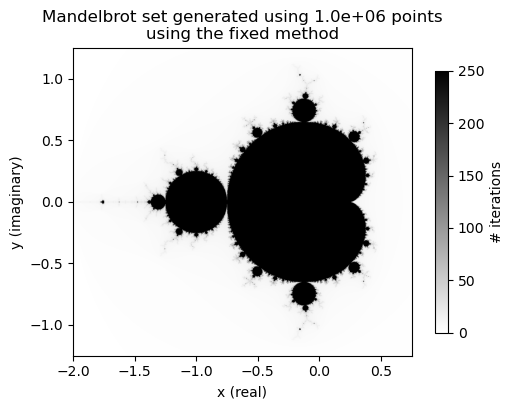

In [88]:
points_fixed, counts_fixed = mandelbrot_parallel_fixed()
mandelbrot_statistics(points_fixed, counts_fixed, method='fixed')
plot_mandelbrot(points_fixed, counts_fixed, method='fixed')

Mandelbrot area: 1.528374375 using monte-carlo method
Mean estimated area: 1.5283743750000004e-06
Standard deviation of estimated area: 2.858610461329442e-06
95% Confidence interval for the estimated area: (1.5227716014499653e-06, 1.5339771485500354e-06)


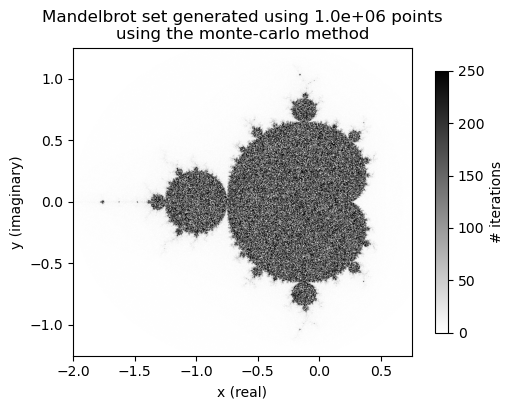

In [89]:
points_mc, counts_mc = mandelbrot_parallel_mc()
mandelbrot_statistics(points_mc, counts_mc, method='monte-carlo')
plot_mandelbrot(points_mc, counts_mc, method='monte-carlo')

In [90]:
def latin_hypercube_samples(n_samples, d=2):
    sampler = qmc.LatinHypercube(d=d)
    return np.array(sampler.random(n=n_samples))

@jit(nopython=True, parallel=True)
def latin_hypercube_sampling(max_iter, n_samples, sample):
    """
    Perform Latin Hypercube Sampling to estimate the area of the Mandelbrot set.
    
    Latin Hypercube Sampling improves sample diversity by ensuring that each sample
    is the only one in each axis-aligned hyperplane. It is particularly useful in 
    multi-dimensional Monte Carlo simulations where it reduces the variability of the results.
    
    :param max_iter: Maximum iterations 
    :param n_samples: Number of samples
    :return: A tuple of sampled complex points and their Mandelbrot iteration counts
    """
    range_real = X_LIM[1] - X_LIM[0]
    range_imag = Y_LIM[1] - Y_LIM[0]
    points = np.zeros((n_samples, 2))
    points[:, 0] = X_LIM[0] + sample[:, 0] * range_real
    points[:, 1] = Y_LIM[0] + sample[:, 1] * range_imag
    c_points = points[:, 0] + 1j * points[:, 1]
    counts = np.zeros((n_samples), dtype=np.int32)
    for i in prange(n_samples):
        counts[i] = mandelbrot(c_points[i], max_iter)
    return c_points, counts

In [91]:
@jit(nopython=True, parallel=True)
def stratified_sampling(max_iter, n_strata, samples_per_stratum):
    """
    Utilize stratified sampling to estimate the Mandelbrot set area.
    
    Stratified sampling ensures that the samples are evenly distributed across the 
    domain of interest, which can lead to more accurate and reliable estimates of the Mandelbrot set area.
    
    :param max_iter: Maximum iterations for Mandelbrot calculations.
    :param n_strata: Number of strata to divide the sample space.
    :param samples_per_stratum: Number of samples per stratum.
    :return: A tuple of sampled complex points and their Mandelbrot iteration counts.
    """
    real_strata_edges = np.linspace(*X_LIM, n_strata + 1)
    imag_strata_edges = np.linspace(*Y_LIM, n_strata + 1)
    
    c_points = np.zeros(n_strata * n_strata * samples_per_stratum, dtype=np.complex128)
    counts = np.zeros(n_strata * n_strata * samples_per_stratum, dtype=np.int32)
    
    index = 0
    for i in prange(n_strata):
        for j in prange(n_strata):
            real_samples = np.random.uniform(real_strata_edges[i], real_strata_edges[i+1], samples_per_stratum)
            imag_samples = np.random.uniform(imag_strata_edges[j], imag_strata_edges[j+1], samples_per_stratum)
            
            for k in range(samples_per_stratum):
                c = real_samples[k] + 1j * imag_samples[k]
                c_points[index] = c
                counts[index] = mandelbrot(c, max_iter)
                index += 1

    return c_points, counts

In [92]:
def investigate_convergence_2d(iter_range, sample_sizes, improvement_method=None):
    """
    Explore the convergence behavior of the Mandelbrot set area estimation as a function of
    iterations and sample size, and assess the efficacy of different sampling methods.

    :param iter_range: A range of iteration counts to test.
    :param sample_sizes: A range of sample sizes to test.
    :param improvement_method: The sampling method used to improve convergence.
    :return: A DataFrame with the area estimates and associated statistics.
    """
    results_list = []

    progress_bar = tqdm(total=len(iter_range) * len(sample_sizes), desc='Convergence Analysis', leave=False)
    # Iterate over all combinations of iteration counts and sample sizes.
    for max_iter in iter_range:
        for n_samples in sample_sizes:
            progress_bar.set_postfix({'max_iter': max_iter, 'n_samples': n_samples}, refresh=True)
            # Ensure a balance between iterations and sample size to compare their errors.
            if n_samples >= max_iter:
                # Apply the appropriate sampling method.
                if improvement_method == 'lhs':
                    sample = latin_hypercube_samples(n_samples)
                    c_points, counts = latin_hypercube_sampling(max_iter, n_samples, sample)
                elif improvement_method == 'stratified':
                    n_strata = int(np.sqrt(n_samples))
                    samples_per_stratum = n_samples // n_strata
                    c_points, counts = stratified_sampling(max_iter, n_strata, samples_per_stratum)
                else:
                    c_points, counts = mandelbrot_parallel_mc(max_iter, n_samples)

                # Calculate statistics for the current configuration.
                stats = mandelbrot_statistics(c_points, counts, method=improvement_method or 'monte-carlo', print_output=False)
                results_list.append({
                    'iterations': max_iter,
                    'samples': n_samples,
                    'estimated_area': stats['area'],
                    'std_dev': stats['std'],
                    'conf_int_low': stats['conf_int'][0],
                    'conf_int_high': stats['conf_int'][1]
                })
            progress_bar.update(1)

    # Compile the results into a DataFrame for further analysis.
    results_df = pd.DataFrame(results_list)

    # Analyze and visualize the convergence behavior.
    visualize_convergence_analysis(results_df, iter_range, sample_sizes)

    return results_df

def visualize_convergence_analysis(results_df, iter_range, sample_sizes):
    """
    Generate plots to visualize the error in estimated area as a function of iteration count
    and sample size, based on reference areas from the convergence study.

    :param results_df: DataFrame containing the results of the convergence study.
    :param iter_range: Range of iteration counts used in the study.
    :param sample_sizes: Range of sample sizes used in the study.
    """
    largest_i = max(iter_range)
    reference_area_by_iter = results_df[results_df['samples'] == max(sample_sizes)].set_index('iterations')['estimated_area']
    reference_area_by_samples = results_df[results_df['iterations'] == max(iter_range)].set_index('samples')['estimated_area']

    plot_error_by_iteration(results_df, iter_range, sample_sizes, reference_area_by_iter)
    plot_error_by_sample_size(results_df, iter_range, sample_sizes, reference_area_by_samples)

# Split plotting into dedicated functions for clarity and maintainability.
def plot_error_by_iteration(results_df, iter_range, sample_sizes, reference_area_by_iter):
    """
    Plot the error in estimated area as a function of iteration count.
    """
    plt.figure(figsize=(10, 5))
    for sample_size in sample_sizes:
        errors = calculate_errors_by_iteration(results_df, iter_range, sample_size, reference_area_by_iter)
        plt.plot(iter_range, errors, '-o', label=f'Samples={sample_size}')
    plt.xlabel('Iteration Count')
    plt.ylabel('Error from reference area by iteration')
    plt.legend()
    plt.title('Error Analysis for Varying Iteration Counts')
    plt.grid(True)
    plt.show()

def plot_error_by_sample_size(results_df, iter_range, sample_sizes, reference_area_by_samples):
    """
    Plot the error in estimated area as a function of sample size.
    """
    plt.figure(figsize=(10, 5))
    for iter_count in iter_range:
        errors = calculate_errors_by_sample_size(results_df, iter_count, sample_sizes, reference_area_by_samples)
        plt.plot(sample_sizes, errors, '-o', label=f'Iterations={iter_count}')
    plt.xlabel('Sample Size')
    plt.ylabel('Error from reference area by sample size')
    plt.legend()
    plt.title('Error Analysis for Varying Sample Sizes')
    plt.grid(True)
    plt.show()

def calculate_errors_by_iteration(results_df, iter_range, sample_size, reference_area_by_iter):
    """
    Calculate errors in estimated area for a fixed sample size across different iteration counts.
    """
    errors = []
    for iter_count in iter_range:
        if not results_df[(results_df['iterations'] == iter_count) & (results_df['samples'] == sample_size)].empty:
            estimated_area = results_df[(results_df['iterations'] == iter_count) & (results_df['samples'] == sample_size)]['estimated_area'].iloc[0]
            ref_area = reference_area_by_iter[iter_count]
            errors.append(abs(estimated_area - ref_area))
    return errors

def calculate_errors_by_sample_size(results_df, iter_count, sample_sizes, reference_area_by_samples):
    """
    Calculate errors in estimated area for a fixed iteration count across different sample sizes.
    """
    errors = []
    for sample_size in sample_sizes:
        if not results_df[(results_df['iterations'] == iter_count) & (results_df['samples'] == sample_size)].empty:
            estimated_area = results_df[(results_df['iterations'] == iter_count) & (results_df['samples'] == sample_size)]['estimated_area'].iloc[0]
            ref_area = reference_area_by_samples[sample_size]
            errors.append(abs(estimated_area - ref_area))
    return errors

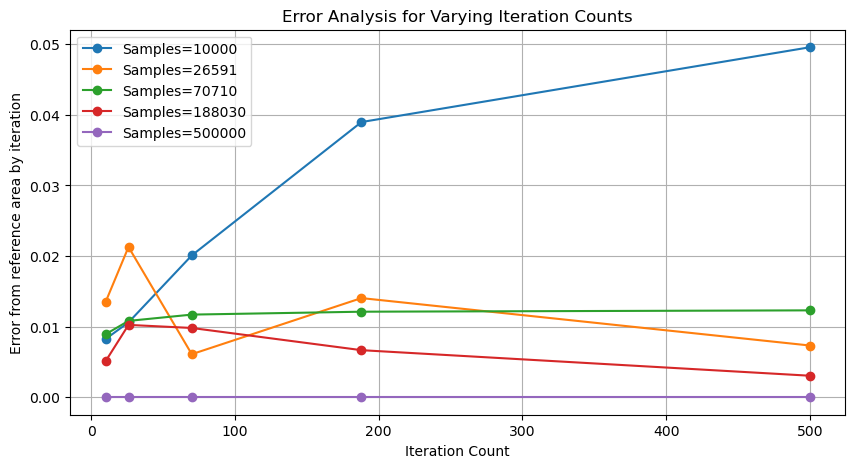

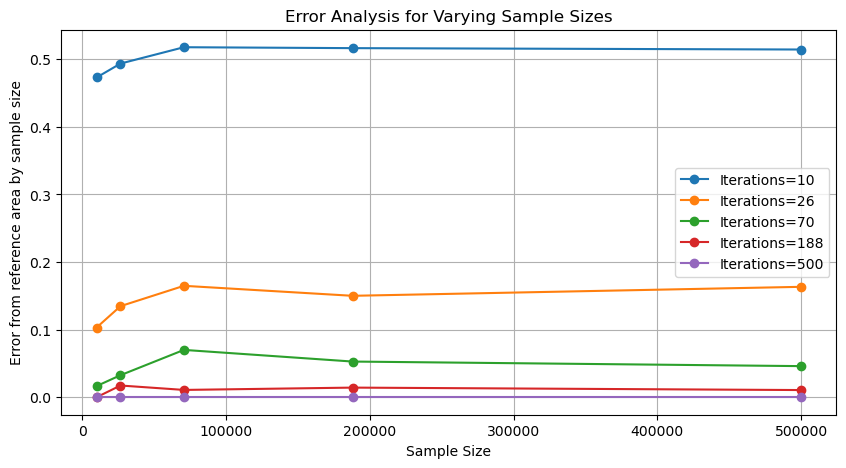

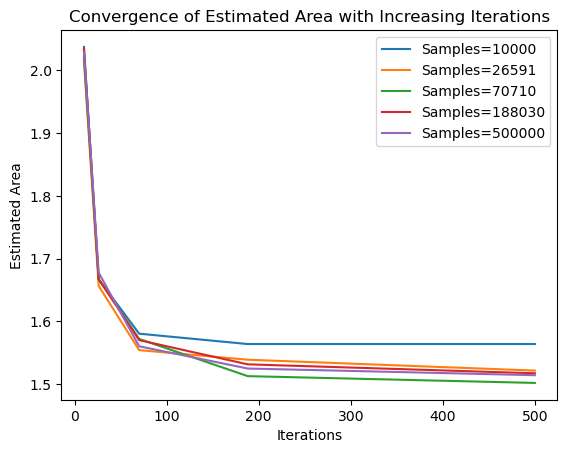

In [93]:
iter_range = np.geomspace(10, 500, num=5).astype(int)  
sample_sizes = np.geomspace(10000, 500000, num=5).astype(int) 
results_df = investigate_convergence_2d(iter_range, sample_sizes)

# Visualizes convergence of set area with increasing iterations
for samples in sample_sizes:
    subset = results_df[results_df['samples'] == samples]
    plt.plot(subset['iterations'], subset['estimated_area'], label=f'Samples={samples}')

plt.xlabel('Iterations')
plt.ylabel('Estimated Area')
plt.legend()
plt.title('Convergence of Estimated Area with Increasing Iterations')
plt.show()

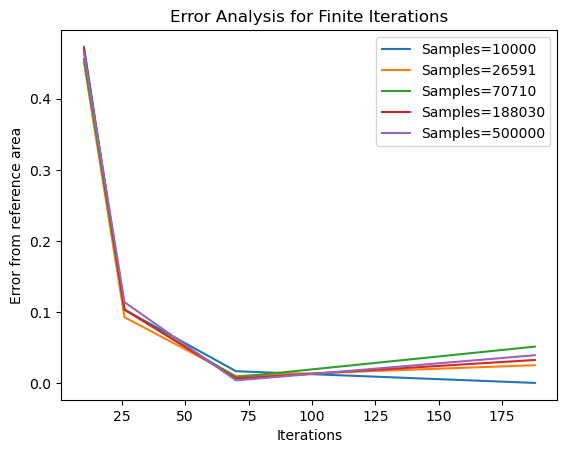

In [94]:
# Analyzes error from reference area for iteration counts
largest_i = max(iter_range)
reference_area = results_df[results_df['iterations'] == largest_i]['estimated_area'].iloc[0]

# Compare error as function of iteration count to largest iteration count
for samples in sample_sizes:
    errors = []
    for i in iter_range:
        if i < largest_i:
            current_area = results_df[(results_df['iterations'] == i) & (results_df['samples'] == samples)]['estimated_area'].iloc[0]
            error = abs(current_area - reference_area)
            errors.append(error)
    plt.plot(iter_range[:-1], errors, label=f'Samples={samples}')

plt.xlabel('Iterations')
plt.ylabel('Error from reference area')
plt.legend()
plt.title('Error Analysis for Finite Iterations')
plt.show()

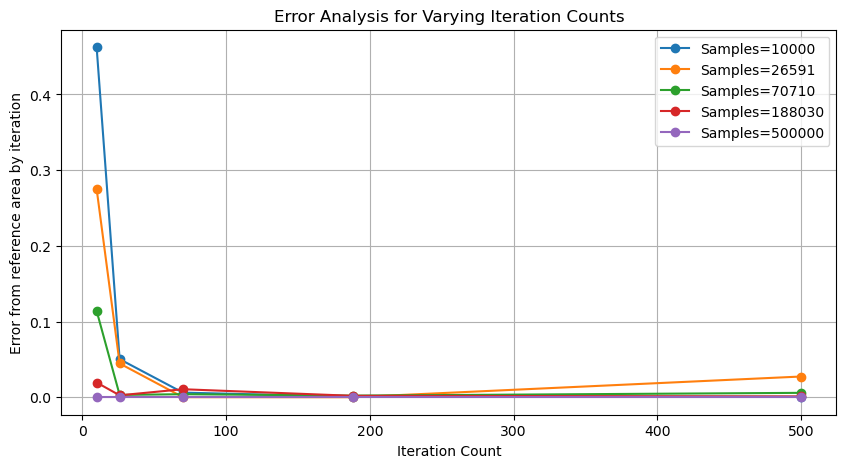

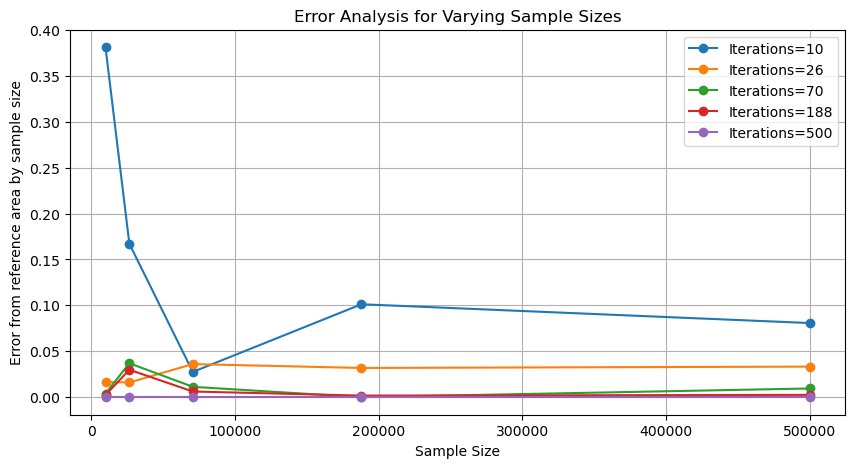

In [95]:
results_df = investigate_convergence_2d(iter_range, sample_sizes, improvement_method='stratified') 

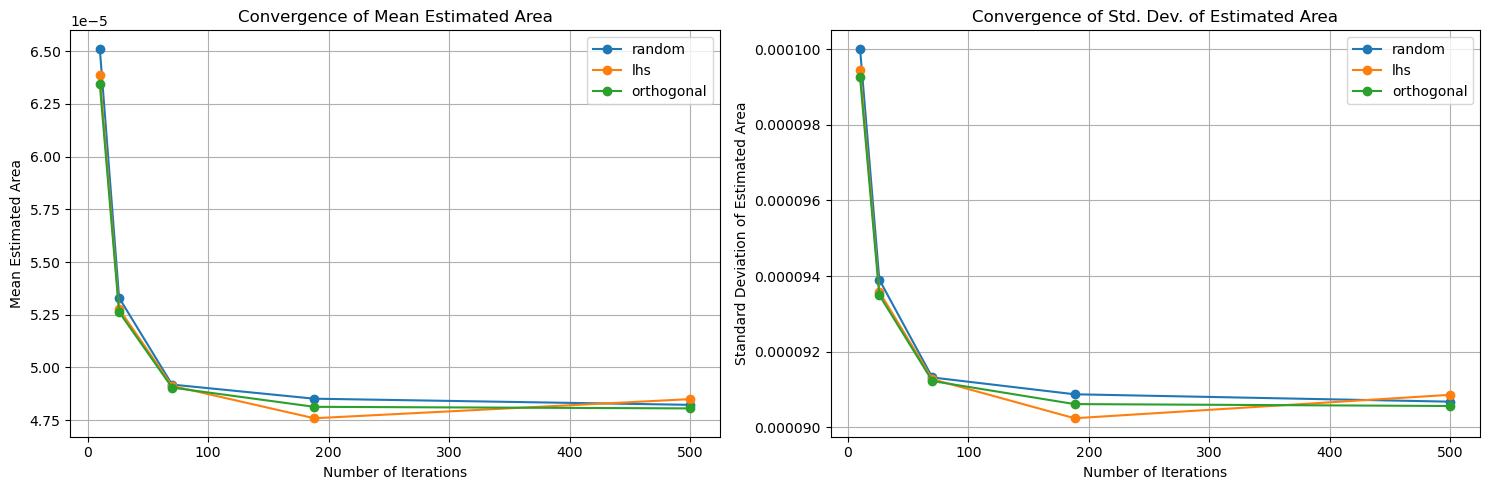

In [96]:
def orthogonal_sampling(max_iter, n_samples, d=2):
    """
    Generate orthogonal samples within the Mandelbrot set limits. Orthogonal sampling is based on Latin Hypercube Sampling (LHS) but imposes a more regular distribution.
    :param max_iter: maximum number of iterations per sample
    :param n_samples: Total number of points to sample
    :param d: Dimension of the sampling grid, default is 2D
    :return: A tuple of complex points and their respective Mandelbrot set iteration counts
    """
    intervals = np.linspace(0, 1, int(np.sqrt(n_samples)) + 1)
    points = np.array(np.meshgrid(*([intervals]*d))).T.reshape(-1, d)
    np.random.shuffle(points)
    points = points[:n_samples]
    
    range_real = X_LIM[1] - X_LIM[0]
    range_imag = Y_LIM[1] - Y_LIM[0]
    sampled_points = np.zeros((n_samples, 2))
    sampled_points[:, 0] = X_LIM[0] + points[:, 0] * range_real
    sampled_points[:, 1] = Y_LIM[0] + points[:, 1] * range_imag
    c_points = sampled_points[:, 0] + 1j * sampled_points[:, 1]
    counts = np.array([mandelbrot(c, max_iter) for c in c_points])
    return c_points, counts

def antithetic_variates(c_points, counts, max_iter):
    """
    Use antithetic variates to potentially reduce variance in the Monte Carlo simulation. This function takes the negation of complex points as antithetic variates.
    :param c_points: Array of complex points sampled
    :param counts: Array of iteration counts
    :param max_iter: Maximum iterations for set membership
    :return: Averaged counts combining original and antithetic variates
    """
    antithetic_points = -c_points
    antithetic_counts = np.array([mandelbrot(c, max_iter) for c in antithetic_points])
    return (counts + antithetic_counts) / 2  # Take the average of normal and antithetic counts

def run_simulation(max_iter, n_samples, sampling_method, sim_runs=10):
    """
    Run multiple simulations of Mandelbrot set calculations using a specified sampling method.
    :param max_iter: Maximum iterations for set membership
    :param n_samples: Number of samples
    :param sampling_method: The method used for sampling points ('random', 'lhs', 'orthogonal')
    :param sim_runs: Number of simulations to run
    :return: A list of statistical summaries from each simulation run
    """
    stats_list = []
    for _ in range(sim_runs):
        if sampling_method == 'random':
            c_points, counts = mandelbrot_parallel_mc(max_iter, n_samples)
            counts = antithetic_variates(c_points, counts, max_iter)  # Use antithetic variates
        elif sampling_method == 'lhs':
            sample = latin_hypercube_samples(n_samples)
            c_points, counts = latin_hypercube_sampling(max_iter, n_samples, sample)
        elif sampling_method == 'orthogonal':
            c_points, counts = orthogonal_sampling(max_iter, n_samples)
        else:
            raise ValueError(f"Unknown sampling method: {sampling_method}")
        stats_list.append(mandelbrot_statistics(c_points, counts, sampling_method))
    return stats_list

def investigate_convergence_3d(iter_range, sample_sizes, methods):
    """
    Investigate the convergence of estimated Mandelbrot set area across different iteration ranges and sampling sizes.
    :param iter_range: The range of iteration counts to test.
    :param sample_sizes: The range of sample sizes to test.
    :param methods: The sampling methods to use in the investigation.
    :return: A dictionary with the mean and standard deviation of estimated areas for each method.
    """
    mean_estimated_areas = {method: [] for method in methods}
    std_dev_estimated_areas = {method: [] for method in methods}
    
    for max_iter in iter_range:
        for method in methods:
            mean_area_for_iter = []
            std_dev_for_iter = []

            for n_samples in sample_sizes:
                if method == 'random':
                    c_points, counts = mandelbrot_parallel_mc(max_iter, n_samples)
                elif method == 'lhs':
                    sample = latin_hypercube_samples(n_samples)
                    c_points, counts = latin_hypercube_sampling(max_iter, n_samples, sample)
                elif method == 'orthogonal':
                    c_points, counts = orthogonal_sampling(max_iter, n_samples)
                else:
                    raise ValueError(f"Unknown sampling method: {method}")
                
                stats = mandelbrot_statistics(c_points, counts, method, print_output=False)

                mean_area_for_iter.append(stats['mean'])
                std_dev_for_iter.append(stats['std'])

            mean_estimated_areas[method].append(np.mean(mean_area_for_iter))
            std_dev_estimated_areas[method].append(np.mean(std_dev_for_iter))

    return mean_estimated_areas, std_dev_estimated_areas

methods = ['random', 'lhs', 'orthogonal']
mean_areas, std_dev_areas = investigate_convergence_3d(iter_range, sample_sizes, methods)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for method in methods:
    plt.plot(iter_range, mean_areas[method], '-o', label=method)
plt.xlabel('Number of Iterations')
plt.ylabel('Mean Estimated Area')
plt.title('Convergence of Mean Estimated Area')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for method in methods:
    plt.plot(iter_range, std_dev_areas[method], '-o', label=method)
plt.xlabel('Number of Iterations')
plt.ylabel('Standard Deviation of Estimated Area')
plt.title('Convergence of Std. Dev. of Estimated Area')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [97]:
# Calvin
c_points, counts = mandelbrot_parallel_mc()
inside_points = c_points[counts == max(counts)] # Assuming > 1 member of the set

max_iter = 250
total_area = (X_LIM[1] - X_LIM[0]) * (Y_LIM[1] - Y_LIM[0])

# Calculate the PDF from the points obtained in the initial simulation
def compute_importance_sampling_distribution(points, bins=10000, epsilon=1e-5):
    hist, _, _ = np.histogram2d(points.real, points.imag, bins=bins, range=[X_LIM, Y_LIM])
    pdf = hist / np.sum(hist) + epsilon  # Adding a small constant to avoid zero probabilities
    return pdf / np.sum(pdf)  # Normalizing

def generate_samples_with_importance_sampling(pdf, num_samples):
    x_edges = np.linspace(*X_LIM, len(pdf[0]) + 1)
    y_edges = np.linspace(*Y_LIM, len(pdf) + 1)

    # Create a 2D grid of indices
    x_indices, y_indices = np.meshgrid(range(len(pdf[0])), range(len(pdf)))
    flattened_indices = np.array([x_indices.flatten(), y_indices.flatten()]).T

    # Choose random indices based on flattened PDF
    chosen_indices = np.random.choice(len(flattened_indices), size=num_samples, p=pdf.flatten())
    # Map the sampled indices to complex numbers
    sampled_points = np.array([complex(x_edges[x], y_edges[y]) for x, y in flattened_indices[chosen_indices]])

    return sampled_points

def estimate_mandelbrot_area_with_importance_sampling(sampled_points):
    points_inside_set = [point for point in sampled_points if mandelbrot(point, max_iter) == max_iter]
    area_estimate = len(points_inside_set) / len(sampled_points) * total_area
    return area_estimate

pdf = compute_importance_sampling_distribution(inside_points)
new_samples = generate_samples_with_importance_sampling(pdf, 100000)
area_estimate = estimate_mandelbrot_area_with_importance_sampling(new_samples)

print(f"Estimated Mandelbrot set area with importance sampling: {area_estimate}")


Estimated Mandelbrot set area with importance sampling: 1.5376625


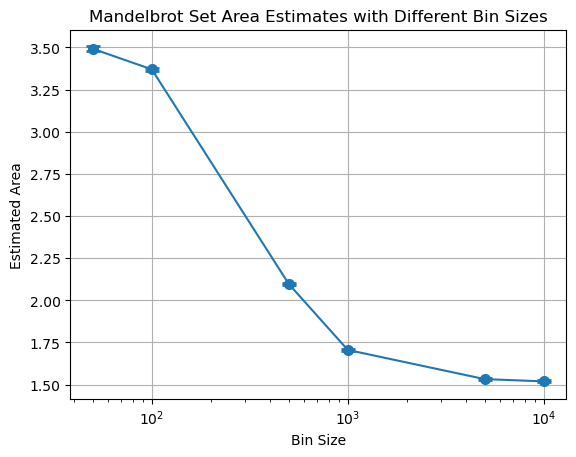

In [101]:
# Calvin

bin_sizes = [50, 100, 500, 1000, 5000, 10000]  
num_repetitions = 5  
mean_estimates = []
std_devs = []

for bins in bin_sizes:
    estimates = []
    for _ in range(num_repetitions):
        pdf = compute_importance_sampling_distribution(inside_points, bins=bins)
        new_samples = generate_samples_with_importance_sampling(pdf, 100000)
        area_estimate = estimate_mandelbrot_area_with_importance_sampling(new_samples)
        estimates.append(area_estimate)

    mean_estimates.append(np.mean(estimates))
    std_devs.append(np.std(estimates))
    
plt.errorbar(bin_sizes, mean_estimates, yerr=std_devs, fmt='-o', capsize=5, elinewidth=2, markeredgewidth=2)
plt.xlabel('Bin Size')
plt.ylabel('Estimated Area')
plt.title('Mandelbrot Set Area Estimates with Different Bin Sizes')
plt.xscale('log') 
plt.yscale('linear') 
plt.grid(True)




































Sample Size Analysis: 100%|██████████| 5/5 [02:14<00:00, 26.86s/it]


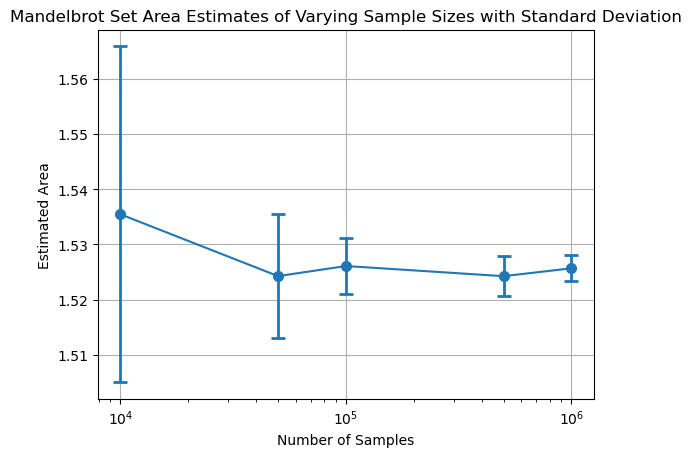

In [102]:
# Calvin

sample_sizes = [10000, 50000, 100000, 500000, 1000000]
num_repetitions = 5
mean_estimates = []
std_devs = []

for num_samples in tqdm(sample_sizes, desc='Sample Size Analysis', leave=True, position=0):
    estimates = []
    for _ in tqdm(range(num_repetitions), desc='Repetition', leave=False, position=1):
        pdf = compute_importance_sampling_distribution(inside_points)
        new_samples = generate_samples_with_importance_sampling(pdf, num_samples)
        area_estimate = estimate_mandelbrot_area_with_importance_sampling(new_samples)
        estimates.append(area_estimate)

    mean_estimates.append(np.mean(estimates))
    std_devs.append(np.std(estimates))

plt.errorbar(sample_sizes, mean_estimates, yerr=std_devs, fmt='-o', capsize=5, elinewidth=2, markeredgewidth=2)
plt.xlabel('Number of Samples')
plt.ylabel('Estimated Area')
plt.title('Mandelbrot Set Area Estimates of Varying Sample Sizes with Standard Deviation')
plt.xscale('log')  
plt.yscale('linear')  
plt.grid(True)

plt.show()

Sample Size Analysis: 100%|██████████| 9/9 [04:36<00:00, 30.67s/it]


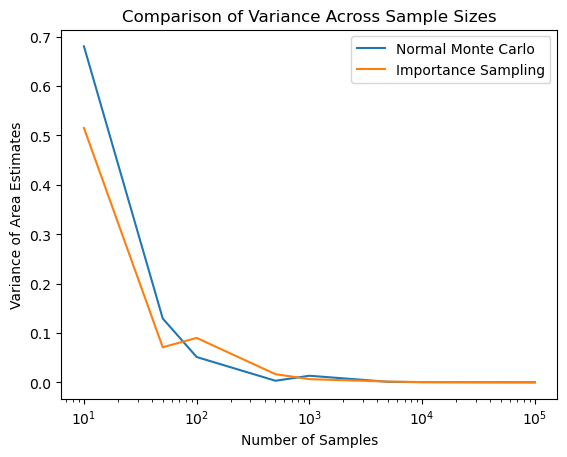

In [106]:
def variance_normal_mc(max_iter, n_points, repetitions):
    estimates = []
    for _ in range(repetitions):
        c_points, counts = mandelbrot_parallel_mc(max_iter, n_points)
        inside_points = c_points[counts == max(counts)] # Assuming > 1 member of the set
        area_estimate = len(inside_points) / n_points * total_area
        estimates.append(area_estimate)
    return np.var(estimates)

def variance_importance_sampling(max_iter, n_points, repetitions):
    pdf = compute_importance_sampling_distribution(inside_points)
    estimates = []
    for _ in range(repetitions):
        new_samples = generate_samples_with_importance_sampling(pdf, n_points)
        area_estimate = estimate_mandelbrot_area_with_importance_sampling(new_samples)
        estimates.append(area_estimate)
    return np.var(estimates)

sample_sizes = [10, 50, 100, 500, 1_000, 5_000, 10_000, 50_000, 100_000]
repetitions = 10 

def variance_experiment(sample_sizes, repetitions, print_intermed=True):
    variances_normal_mc = []
    variances_importance_sampling = []

    for n_points in tqdm(sample_sizes, desc='Sample Size Analysis', leave=True):
        var_normal_mc = variance_normal_mc(max_iter, n_points, repetitions)
        var_importance_sampling = variance_importance_sampling(max_iter, n_points, repetitions)
        variances_normal_mc.append(var_normal_mc)
        variances_importance_sampling.append(var_importance_sampling)
        if print_intermed:
            print(f"Sample Size: {n_points}, Variance Normal MC: {var_normal_mc}, Variance Importance Sampling: {var_importance_sampling}")

    return variances_normal_mc, variances_importance_sampling

variances_normal_mc, variances_importance_sampling = variance_experiment(sample_sizes, repetitions, print_intermed=False)

plt.semilogx(sample_sizes, variances_normal_mc, label='Normal Monte Carlo')
plt.semilogx(sample_sizes, variances_importance_sampling, label='Importance Sampling')
plt.xlabel('Number of Samples')
plt.ylabel('Variance of Area Estimates')
plt.title('Comparison of Variance Across Sample Sizes')
plt.legend()
plt.show()